# Fashion classification with linear models
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

In [2]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(41081)
X, y = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

KeyboardInterrupt: 

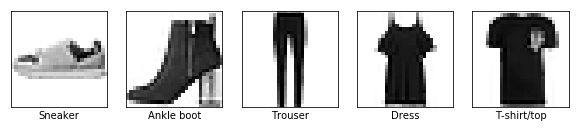

In [22]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[y[n]]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Quick benchmark
First, we'll try the default Logistic Regression and Linear SVMs. We'll also throw in k-Nearest Neighbors as a point of reference. To see whether or models are overfitting, we also evaluate the training set error. This can be done using `cross_validate` instead of  `cross_val_scores`

In [4]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

# Evaluate with 3-fold cross-validation.
clfs = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
xvals = [cross_validate(clf, Xs, ys, return_train_score= True, n_jobs=-1) for clf in clfs]

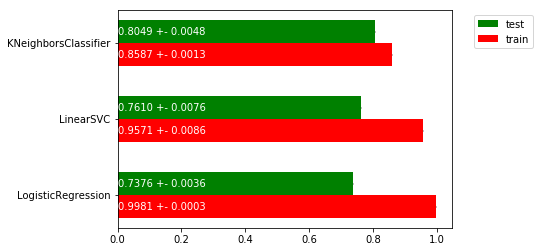

In [5]:
# Plotting
fig, ax = plt.subplots()
width=0.3
test_scores = [x['test_score'] for x in xvals]
train_scores = [x['train_score'] for x in xvals]
ax.barh(np.arange(len(xvals)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(xvals))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(xvals)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(xvals))-width/2, yticklabels=[c.__class__.__name__ for c in clfs])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

k-NN has the best cross-validated test set performance. The two linear model perform noticeably worse, and both also have a very high training set error. This indicates that both linear models are likely overfitted and need to be regularized. The standard deviation of the results is very small: the error bars are hardly noticeable.

## Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}] and for n_neighbors between 1 and 50. We run a grid search over these ranges, using 3-fold cross-valdation, and plot both the training and test error.

In [6]:
from sklearn.model_selection import GridSearchCV

param_c = {'C': np.logspace(-12, 12, num=22)}
param_k = {'n_neighbors': np.geomspace(1, 60, num=12, dtype=int)[1:]}
grids = [param_c,param_c,param_k]
grid_searches = [GridSearchCV(clf,grid,n_jobs=-1).fit(Xs,ys) for clf,grid in zip(clfs,grids)]

In [7]:
# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name, ax):
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp,bs,"  C:{:.2E}, ACC:{:.4f}".format(bp,bs))

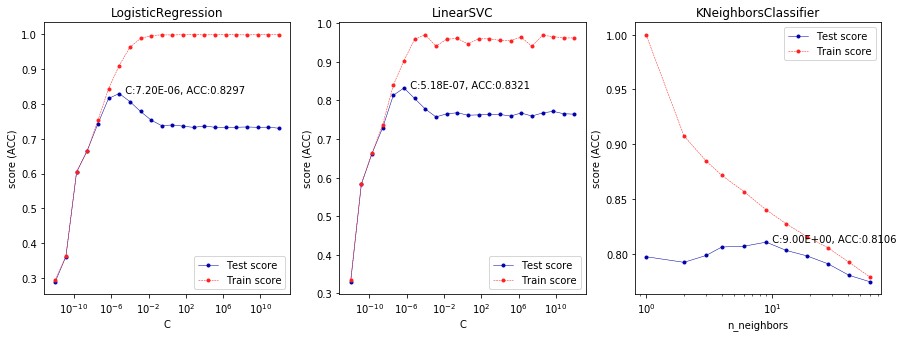

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches,['C','C','n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

We find that, when properly regularized, the linear models both outperform kNN, and that linear SVMs seem to do slighty better of these two. Logistic regression underfits for small values of C, reaches an optimum around C=1e-6, and then starts overfitting. The linear SVM behaves the same way, but with an optimum around C=1e-8. The kNN overfits for small numbers of neighbors, reaches an optimum around n_neighbors=4, and then starts overfitting gradually. Note that these results were obtained on a 10% subsample. Results may be different when we optimize our models on the entire datset.

## Interpreting misclassifications
Our best model was logistic regression, but it is only about 82% accurate. Let's take a closer look at which instances are misclassified and which classes are often confused.

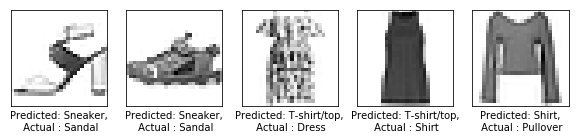

In [21]:
# Create a stratified train-test split on on sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)
# Fit the optimized model and generate prediction
y_pred = LogisticRegression(C=1e-6).fit(X_train,y_train).predict(X_test)
misclassified_samples = np.nonzero(y_pred != y_test)[0]

# Show first five
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[y_pred[i]],fmnist_classes[y_test[i]]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

Some of these seem quite common mistakes, such as confusing shirts and T-shirts. Others, like misclassifying sandals for sneakers, seem more curious. The second example actually looks more like a sneaker than a sandal, and may be mislabelled in the training data. Let's draw the complete confusion matric to get more insight.

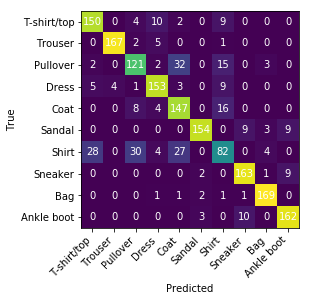

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

We see that some categories are much easier to predict than others. For instance, trousers and bags are almost always predicted correctly, while sneakers are occasionally confused with sandals or boots. Shirts, on the other hand, are misclassified about half of the time, predominantly confused with t-shirts, pullovers, and coats.

## Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

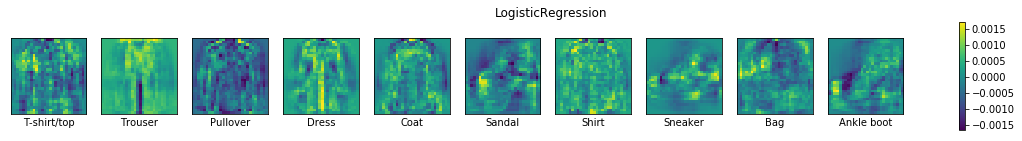

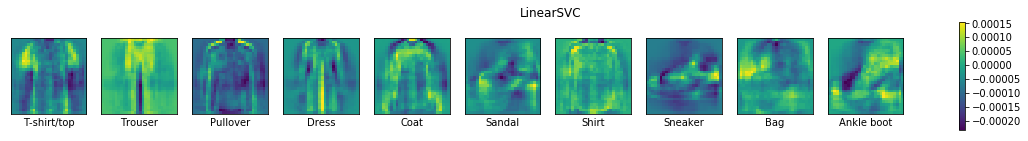

In [18]:
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())
plot_coefficients(LogisticRegression(C=1e-6).fit(X_train,y_train))
plot_coefficients(LinearSVC(C=1e-8).fit(X_train,y_train))

Remember that linear models are typically binary classifiers. They will solve multi-class problems in a one-vs-all approach. Hence, for a 10-class problem, they will build 10 models, each one trained to predict whether an instance is from a specific class or not. This leads to 10 sets of 784 trained coefficients. Above, we plot them as 28x28 matrices, such that each coefficient is plotted at the location of their corresponding pixel value.

Very high values for coefficients (bright pixels in the images) or very low values (dark pixels in the images)
cause the corresponding pixel values to have a large effect on the final prediction. In other words, the very bright and very dark pixels in the images are the pixels that the model is mainly 'looking' at to make a prediction. We can easily recognize the shapes of the fashion items for each class. For instance, for classifying a t-shirt (yes or no), the model will blow up the pixel values near the edges of the shirt, and especially near the shoulders, while it will suppress the background pixel values near the outlines of the shirt. If the sum of all these values is large, it will likely lead to a positive prediction for that class.

We can also see that some classes are less defined than others in these images, and these are typically the classes which are easily confused for other classes.

Both models seem to focus on the same coefficients, yielding very similar images, yet smoother for the SVM.  Moreover, the Linear SVM uses much smaller coefficients.

Finally, out of curiosity, let's see the result of underfitting and overfitting on the learned coefficients:

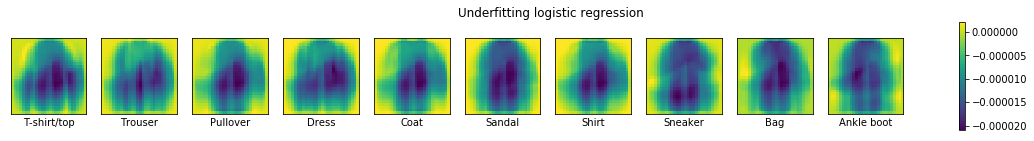

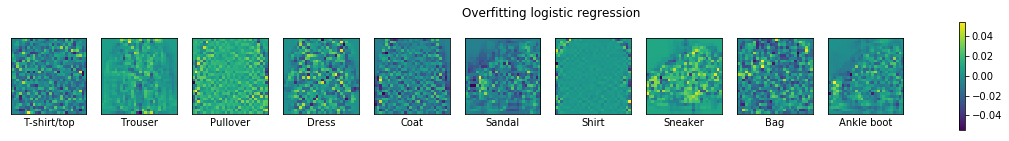

In [12]:
plot_coefficients(LogisticRegression(C=1e-10).fit(X_train,y_train),"Underfitting logistic regression")
plot_coefficients(LogisticRegression(C=1e+10).fit(X_train,y_train),"Overfitting logistic regression")

In the case that we underfit the logistic regression model, we see that the model does not pay enough attention to the pixels that are relevant to make a good prediction. In fact, the coefficients are very similar regardless of the target class. The coefficients are nearly zero, and can't distinguish any meaningful patterns in the data. 

If we overfit the model, it pays attention to seemingly random pixels, including pixels that are simply background pixels. The coefficients are much higher (or much more negative), meaning that the model can yield different predictions for only slight variations in the input pixel value.

We can expect similar behavior from under- or overfitted linear SVMs.